Basic framework for to explore the effects of white-box evasion attacks on the MNIST/CIFAR-10 datasets. Metrics and defences are also explored, the latter mainly involving iamge preprocessing (i.e. input transformations) and adversarial training.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool
from art.defences.preprocessor import TotalVarMin, SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.metrics import empirical_robustness, clever_u
from art.data_generators import KerasDataGenerator
from art.utils import load_mnist, load_cifar10

Section 1 - Attacks

Modification: Disabling eager execution to enable Step 3

In [2]:
tf.compat.v1.disable_eager_execution()

Step 1a: Load the MNIST dataset

In [4]:
#MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
#x_train, y_train = x_train[:5000], y_train[:5000]
#x_test, y_test = x_test[:500], y_test[:500]

Step 1b: Load the CIFAR-10 dataset

In [ ]:
# CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
# x_train, y_train = x_train[:5000], y_train[:5000]
# x_test, y_test = x_test[:500], y_test[:500]

Step 2: Create the model 

In [ ]:
# model = Sequential()
# model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# model.compile(
#     loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
# )

In [ ]:
# def build_model(input_shape=(32, 32, 3), nb_classes=10):
#     img_input = Input(shape=input_shape)
#     conv2d_1 = Conv2D(
#         6,
#         (5, 5),
#         padding="valid",
#         kernel_regularizer=l2(0.0001),
#         activation="relu",
#         kernel_initializer="he_normal",
#         input_shape=input_shape,
#     )(img_input)
#     conv2d_1_bn = BatchNormalization()(conv2d_1)
#     conv2d_1_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv2d_1_bn)
#     conv2d_2 = Conv2D(16, (5, 5), padding="valid", activation="relu", kernel_initializer="he_normal")(conv2d_1_pool)
#     conv2d_2_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv2d_2)
#     flatten_1 = Flatten()(conv2d_2_pool)
#     dense_1 = Dense(120, activation="relu", kernel_initializer="he_normal")(flatten_1)
#     dense_2 = Dense(84, activation="relu", kernel_initializer="he_normal")(dense_1)
#     img_output = Dense(nb_classes, activation="softmax", kernel_initializer="he_normal")(dense_2)
#     model = Model(img_input, img_output)

#     model.compile(
#         loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
#     )

#     return 

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Step 3: Create the ART classifier

In [6]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Step 4: Train the ART classifier

In [7]:
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/5
937/937 [==============================] - 12s 8ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.1664 - accuracy: 0.9454
Epoch 2/5
937/937 [==============================] - 8s 8ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0549 - accuracy: 0.9828
Epoch 3/5
937/937 [==============================] - 8s 8ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0411 - accuracy: 0.9870
Epoch 4/5
937/937 [==============================] - 8s 8ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0357 - accuracy: 0.9889
Epoch 5/5
937/937 [==============================] - 8s 8ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0305 - accuracy: 0.9902


Step 5: Evaluate the ART classifier on benign test examples

In [8]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Undefended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Undefended classifier
Accuracy on benign test examples: 99.24%


Step 6: Craft adversarial examples

In [9]:
adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.2)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv = adv_crafter.generate(x_test)


JSMA:   0%|          | 0/10000 [00:00<?, ?it/s]

Additional step: Plot images and their adversarial counterparts for reference

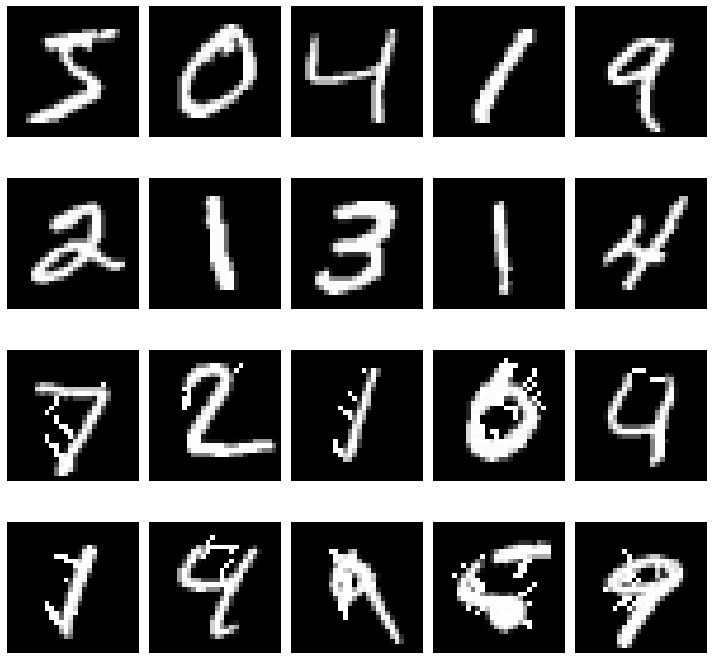

In [10]:
import matplotlib.pyplot as plt

num = 10
images = x_train[:num]
adv_examples = x_test_adv[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

Step 7: Evaluate the ART classifier on the adversarial test set

In [11]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Undefended classifier")
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Undefended classifier
Accuracy on adversarial test examples: 0.19%


Section 2 - Metrics

Metric 1: Empirical Robustness

In [40]:
attack_name = "fgsm"
score = empirical_robustness(classifier=classifier, x=x_test, attack_name=attack_name)
print("Empirical robustness of the classifier against {}: {}".format(attack_name, score))

Empirical robustness of the classifier against fgsm: 0.17202728105614684


Metric 2: CLEVER

In [47]:
score = clever_u(classifier=classifier, x=x_test[1], nb_batches=5, batch_size=64, radius=0.1,norm=np.inf)
print("CLEVER score of the classifier against an untargeted attack: {}".format(score))

CLEVER untargeted:   0%|          | 0/9 [00:00<?, ?it/s]

CLEVER score of the classifier against an untargeted attack: 0.1


Section 3 - Defence

Defence 1: Preprocessing

Step 1: Input transformation

In [ ]:
defence = TotalVarMin(verbose = True)
#defence = SpatialSmoothing(window_size=5)

x_test_adv = defence(x_test_adv * 255)[0] / 255

#what does * 255)[0] / 255 do?

Additional step: Plot transformed adversarial examples for visualization

In [ ]:
num = 10
transformed_adv_examples = x_test_adv[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(transformed_adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

Defence 2: Adversarial Training

Adversarial Training: Method 1 - Data Generators

Step 1: Build a Keras image augmentation object and wrap it in ART

In [ ]:
batch_size = 50

datagen = ImageDataGenerator(
    horizontal_flip=True, width_shift_range=0.125, height_shift_range=0.125, fill_mode="constant", cval=0.0
)
datagen.fit(x_train)
art_datagen = KerasDataGenerator(
    datagen.flow(x=x_train, y=y_train, batch_size=batch_size, shuffle=True),
    size=x_train.shape[0],
    batch_size=batch_size,
)

Step 2: Create adversarial trainer

In [ ]:
adv_trainer = AdversarialTrainer(classifier, attacks=adv_crafter, ratio=1.0)

Step 3: Perform adversarial training

In [ ]:
adv_trainer.fit_generator(art_datagen, nb_epochs=5)

Adversarial Training: Method 2 - Augmented Training Set

Step 1: Data augmentation: expand the training set with the adversarial examples

In [ ]:
x_train = np.append(x_train, x_train_adv, axis=0)
y_train = np.append(y_train, y_train, axis=0)

Step 2: Retrain the model on the extended dataset

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

Defence: Evaluation of effectiveness

Step 1: Evaluate the adversarially trained model on the clean test set

In [ ]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Step 2: Evaluate the adversarially trained model on the original adversarial test set

In [ ]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on original adversarial test examples: {}%".format(accuracy * 100))

Step 3: Evaluate the adversarially trained model on new adversarial examples produced on the adversarially trained model

In [ ]:
x_test_adv = adv_crafter.generate(x_test)

#Following code is for when a preprocessing defence is used
#x_test_adv = defence(x_test_adv * 255)[0] / 255

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on new adversarial test examples: {}%".format(accuracy * 100))